## Assignment 3 Done by: Rahma Nouaji ( 261126792 ) , Sarah Bellemare(261128271) & Aidan Goldfarb ( 261087814) 

# Imports

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
from tensorflow import keras
import tqdm,random
from tqdm import tqdm

from matplotlib import pyplot as plt


In [2]:
!pip install gymnasium

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 7.6 MB/s eta 0:00:00


In [3]:
from  tqdm import tqdm 
import numpy as np 
import gymnasium 
import matplotlib.pyplot as plt

env = gymnasium.make('CartPole-v1')

# Data collection

## Expert Agent data collection from q learning algorithm

In [4]:
class StateDiscretizer:
   def __init__(self, num_bins, lower_bounds, upper_bounds):
        self.num_bins = num_bins
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.bins = [
            np.linspace(lower, upper, num_bins + 1)[1:] 
            for (lower, upper) in zip(lower_bounds, upper_bounds)
             ]
        self.num_features = self(lower_bounds).shape[0]

   def __call__ (self, x):
        x = np.clip(x, self.lower_bounds, self.upper_bounds)
        idx = [np.digitize(x_i, b_i, right=True) for (x_i, b_i) in zip(x, self.bins)]
        one_hots = [np.eye(self.num_bins)[i] for i in idx]
        return np.concatenate(one_hots)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
lower_bounds = env.observation_space.low
upper_bounds = env.observation_space.high
lower_bounds[1]=-3.
lower_bounds[-1]=-3.
upper_bounds[1]=3.
upper_bounds[-1]=3.
phi = StateDiscretizer(10,lower_bounds,upper_bounds)

In [6]:



def q_value(state, weights):
    return phi(state).dot(weights)

def policy(state, weights, epsilon):
    if np.random.uniform() <= epsilon:
        return np.random.choice(env.action_space.n)
    else:
        q_values = q_value(state, weights) 
        return np.argmax(q_values)


In [ ]:
phi(upper_bounds).shape

(40,)

In [7]:
weights = np.random.uniform(low=-0.001, high=0.001, size=(phi.num_features,env.action_space.n))


In [13]:

lr = 1/16

gamma = 0.99

epsilon = 0.1
runs = 10
num_actions= env.action_space.n
episodes = 1000
episode_rewards = np.zeros((runs, episodes))
for run in range(runs):  
  weights = np.random.uniform(low=-0.001, high=0.001, size=(phi.num_features,num_actions))
    
  for i_episode in tqdm(np.arange(episodes)):
        state,_ = env.reset()
        
        total_reward = 0
        done= False
    
        while not done:
             
            action = policy(state, weights,epsilon)
            next_state, reward, done,d2, _ = env.step(action)
         
          
            q_next = np.max(q_value(next_state, weights)) 
            target = reward + gamma *(1. - done)* q_next
            error =  q_value(state, weights)[action] - target

            
            
            delta =  error * phi(state)
            weights[:,action] -= lr *  delta

            state = next_state
            total_reward += reward
            
        episode_rewards[run, i_episode] = total_reward
     



100%|██████████| 1000/1000 [00:32<00:00, 30.94it/s]


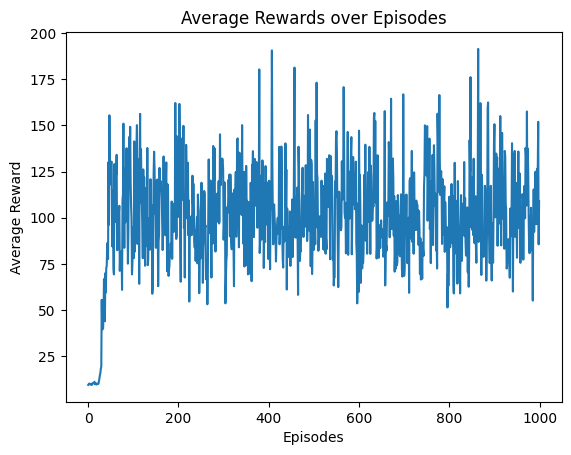

In [14]:
mean_rewards = np.mean(episode_rewards, axis=0)
plt.plot(mean_rewards)
# add x-axis label
plt.xlabel('Episodes')

# add y-axis label
plt.ylabel('Average Reward')

# add plot title
plt.title('Average Rewards over Episodes')
plt.show()

In [16]:
state,_ = env.reset()

total_reward = 0
done= False

while not done:
      action = policy(state, weights, 0)  # select action greedily
      next_state, reward, done,d2, _ = env.step(action)
    
      state = next_state
      total_reward += reward
print('Testing average rewards for q learning algorithm',total_reward)

Testing average rewards for q learning algorithm 176.0


In [17]:
lr = 1/16

gamma = 0.99

epsilon = 0.1
runs = 1
num_actions= env.action_space.n
expert_episodes = []
episode_lengths = [100, 250, 500]
expert_dataset100=[]
expert_dataset250=[]
expert_dataset500=[]
for num_episodes in episode_lengths:
  for run in range(runs):  
    weights = np.random.uniform(low=-0.001, high=0.001, size=(phi.num_features,num_actions))

    for i_episode in range(num_episodes):
          state,_ = env.reset()

          total_reward = 0
          done= False
          expert_episode = []

          while not done:

              action = policy(state, weights,epsilon)
              next_state, reward, done,_, _ = env.step(action)


              q_next = np.max(q_value(next_state, weights)) 
              target = reward + gamma *(1-done)* q_next
              error =  q_value(state, weights)[action] - target



              delta =  error * phi(state)
              weights[:,action] -= lr *  delta

              expert_episode.append((phi(state), action, reward,phi(next_state),done))
              state = next_state
              
          if num_episodes==100:
            expert_dataset100.append(expert_episode)
          elif num_episodes ==250:
            expert_dataset250.append(expert_episode)
          else:
            expert_dataset500.append(expert_episode)


## Data collected uniformly random 

In [18]:
num_episodes = 100 
episode_length = 200 # Change this to the desired episode length
random_dataset100 = []

for i in range(num_episodes):
    state,_ = env.reset()
    episode_data = []
    
    for t in range(episode_length):
        action = env.action_space.sample() # Randomly select an action
        next_state, reward, done, info,_ = env.step(action)
        
        episode_data.append((phi(state), action,reward,phi(next_state),done))
        state = next_state
        
        if done:
            break
    
    random_dataset100.append(episode_data)


In [19]:
num_episodes = 250 
episode_length = 200 
random_dataset250 = []

for i in range(num_episodes):
    state,_ = env.reset()
    episode_data = []
    done = False
    while not done:
        action = env.action_space.sample() # Randomly select an action
        next_state, reward, done, info,_ = env.step(action)
        
        episode_data.append((phi(state), action,reward,phi(next_state),done))
        state = next_state
        
        
    
    random_dataset250.append(episode_data)

In [20]:
num_episodes = 500 
episode_length = 200 
random_dataset500 = []

for i in range(num_episodes):
    state,_ = env.reset()
    episode_data = []
    
    for t in range(episode_length):
        action = env.action_space.sample() # Randomly select an action
        next_state, reward, done, info,_ = env.step(action)
        
        episode_data.append((phi(state), action,reward,phi(next_state),done))
        state = next_state
        
        if done:
            break
    
    random_dataset500.append(episode_data)

## Mixed dataset 

In [21]:
mixed_data100=random_dataset100[:50]+expert_dataset100[50:100]
mixed_data250=random_dataset250[:125]+expert_dataset250[:125]
mixed_data500 = random_dataset500[:250]+expert_dataset500[:250]



# Imitation learning: Logistic regression

## Random dataset

###Random dataset 100 episodes

#### C=0.1

In [68]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset100 for t in episode])
y = np.hstack([t[1] for episode in random_dataset100 for t in episode])

In [69]:

clf = LogisticRegression(max_iter=1000, C=0.1).fit(X, y)

In [70]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_random100_C1=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ", average_return_random100_C1)




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  27.1


#### C=0.01

In [71]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset100 for t in episode])
y = np.hstack([t[1] for episode in random_dataset100 for t in episode])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:

clf = LogisticRegression(max_iter=1000, C=0.01).fit(X, y)

In [73]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_random100_C01=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ", average_return_random100_C01)




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  26.09


### Random dataset 250 episodes

#### C=0.1

In [74]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset250 for t in episode])
y = np.hstack([t[1] for episode in random_dataset250 for t in episode])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
clf = LogisticRegression(max_iter=1000,C=0.1).fit(X, y)

In [76]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
      
            
    returns.append(episode_return)
average_return_random250_C1=   sum(returns) / len(returns)

# Print the average return over the 100 episodes
print("Average Return for random: ", average_return_random250_C1)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return for random:  18.3


#### C=0.01

In [77]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset250 for t in episode])
y = np.hstack([t[1] for episode in random_dataset250 for t in episode])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
clf = LogisticRegression(max_iter=1000,C=0.01).fit(X, y)

In [79]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
      
            
    returns.append(episode_return)
average_return_random250_C01=   sum(returns) / len(returns)

# Print the average return over the 100 episodes
print("Average Return for random: ", average_return_random250_C01)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return for random:  16.93


### Random dataset 500 episodes

#### C=0.1

In [80]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset500 for t in episode])
y = np.hstack([t[1] for episode in random_dataset500 for t in episode])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
clf = LogisticRegression(max_iter=1000 ,C=0.1).fit(X, y)

In [82]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done= False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
     
            
    returns.append(episode_return)
average_return_random500_C1 = sum(returns) / len(returns) 
# Print the average return over the 100 episodes
print("Average Return for random: ", average_return_random500_C1)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return for random:  94.72


#### C=0.01

In [83]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset500 for t in episode])
y = np.hstack([t[1] for episode in random_dataset500 for t in episode])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
clf = LogisticRegression(max_iter=1000 ,C=0.01).fit(X, y)

In [85]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done= False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
     
            
    returns.append(episode_return)
average_return_random500_C01 = sum(returns) / len(returns) 
# Print the average return over the 100 episodes
print("Average Return for random: ", average_return_random500_C01)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return for random:  102.72


## Expert dataset

### Expert dataset 100 episodes

#### C=0.1

In [86]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset100 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset100 for t in episode])
# # shuffle the rows of X and y in the same order
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
clf = LogisticRegression(max_iter=1000, C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done=False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
      
            
    returns.append(episode_return)
average_return_expert100_C1 = sum(returns) / len(returns) 

# Print the average return over the 100 episodes
print("Average Return for expert: ", average_return_expert100_C1)


Average Return for expert:  199.01


#### C=0.01

In [88]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset100 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset100 for t in episode])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
clf = LogisticRegression(max_iter=1000, C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done=False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
      
            
    returns.append(episode_return)
average_return_expert100_C01 = sum(returns) / len(returns) 

# Print the average return over the 100 episodes
print("Average Return for expert: ", average_return_expert100_C01)


Average Return for expert:  197.61


### Expert dataset 250 episodes

#### C=0.1

In [90]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset250 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset250 for t in episode])
# # shuffle the rows of X and y in the same order
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
clf = LogisticRegression(max_iter=1000,C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state

            
    returns.append(episode_return)
average_return_expert250_C1 = sum(returns) / len(returns) 

# Print the average return over the 100 episodes
print("Average Return for expert: ",average_return_expert250_C1)


Average Return for expert:  196.63


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### C=0.01

In [92]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset250 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset250 for t in episode])
# # shuffle the rows of X and y in the same order
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

In [93]:
clf = LogisticRegression(max_iter=1000,C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state

            
    returns.append(episode_return)
average_return_expert250_C01 = sum(returns) / len(returns) 

# Print the average return over the 100 episodes
print("Average Return for expert: ",average_return_expert250_C01)


Average Return for expert:  196.68


###  Expert dataset 500 episodes

#### C=0.1

In [94]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset500 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset500 for t in episode])
# shuffle the rows of X and y in the same order
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
clf = clf = LogisticRegression(max_iter=1000, C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        
            
    returns.append(episode_return)
average_return_expert500_C1  = sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return for expert: ", sum(returns) / len(returns))

Average Return for expert:  199.4


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### C=0.01

In [96]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset500 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset500 for t in episode])
# shuffle the rows of X and y in the same order
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

In [97]:
clf = LogisticRegression(max_iter=1000, C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        
            
    returns.append(episode_return)
average_return_expert500_C01  = sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return for expert: ", sum(returns) / len(returns))

Average Return for expert:  204.05


## Mixed dataset

###  Mixed dataset 100 episodes

#### C=0.1

In [98]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data100 for t in episode])
y = np.hstack([t[1] for episode in mixed_data100 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
clf = LogisticRegression(max_iter=1000,C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
     
    returns.append(episode_return)
average_return_mixed100_C1  = sum(returns) / len(returns)
    
# Print the average return over the 100 episodes
print("Average Return for mixed: ", sum(returns) / len(returns))

Average Return for mixed:  199.49


#### C=0.01

In [100]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data100 for t in episode])
y = np.hstack([t[1] for episode in mixed_data100 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
clf = LogisticRegression(max_iter=1000,C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
     
    returns.append(episode_return)
average_return_mixed100_C01  = sum(returns) / len(returns)
    
# Print the average return over the 100 episodes
print("Average Return for mixed: ", sum(returns) / len(returns))

Average Return for mixed:  193.88


###  Mixed dataset 250 episodes

#### C=0.1

In [102]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data250 for t in episode])
y = np.hstack([t[1] for episode in mixed_data250 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
clf = LogisticRegression(max_iter=1000,C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_mixed250_C1  = sum(returns) / len(returns)
  
# Print the average return over the 100 episodes
print("Average Return: ", sum(returns) / len(returns))

Average Return:  180.4


#### C=0.01

In [104]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data250 for t in episode])
y = np.hstack([t[1] for episode in mixed_data250 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
clf = LogisticRegression(max_iter=1000,C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_mixed250_C01  = sum(returns) / len(returns)
  
# Print the average return over the 100 episodes
print("Average Return: ", sum(returns) / len(returns))

Average Return:  182.33


###  Mixed dataset 500 episodes

#### C=0.1

In [106]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data500 for t in episode])
y = np.hstack([t[1] for episode in mixed_data500 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
clf = LogisticRegression(max_iter=1000,C=0.1).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
  
            
    returns.append(episode_return)
average_return_mixed500_C1  = sum(returns) / len(returns)
    
# Print the average return over the 100 episodes
print("Average Return: ", sum(returns) / len(returns))

Average Return:  195.47


#### C=0.01

In [108]:
X = np.vstack([np.hstack((t[0])) for episode in mixed_data500 for t in episode])
y = np.hstack([t[1] for episode in mixed_data500 for t in episode])
# shuffle_idx = np.random.permutation(X.shape[0])
# X = X[shuffle_idx]
# y = y[shuffle_idx]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
clf = LogisticRegression(max_iter=1000,C=0.01).fit(X, y)
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state, _ = env.reset()
    episode_return = 0
    done = False
    while not done:
        # Get the action from the policy estimator
        action_probs = clf.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info, _ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
  
            
    returns.append(episode_return)
average_return_mixed500_C01  = sum(returns) / len(returns)
    
# Print the average return over the 100 episodes
print("Average Return: ", sum(returns) / len(returns))

Average Return:  196.75


## Bar chart for the logistic regression

In [110]:
import pandas as pd 
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
avg=[average_return_random100_C1,average_return_random250_C1,average_return_random500_C1,average_return_mixed100_C1,average_return_mixed250_C1,average_return_mixed500_C1,average_return_expert100_C1, average_return_expert250_C1, average_return_expert500_C1]

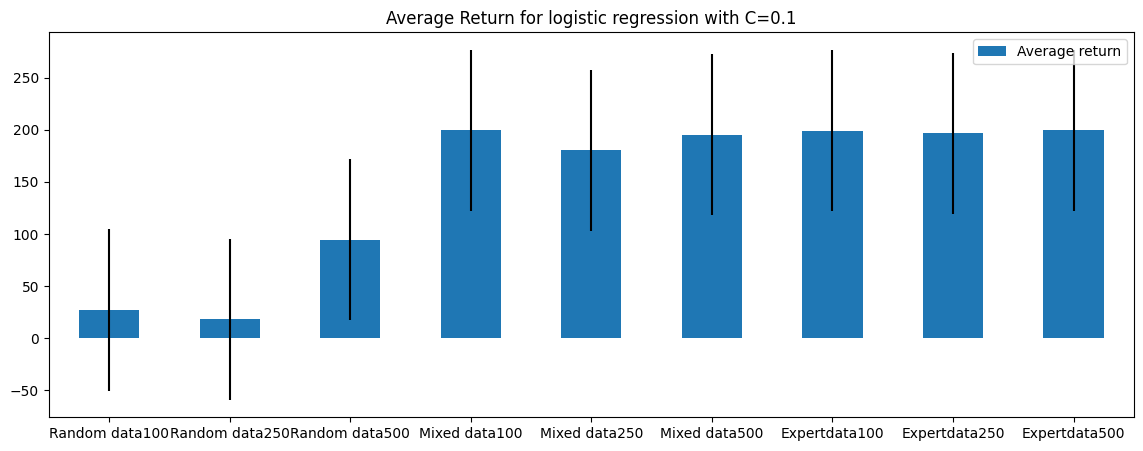

In [112]:

import pandas as pd
import matplotlib.pyplot as plt

# Define the data
avg = [average_return_random100_C1,average_return_random250_C1,average_return_random500_C1,average_return_mixed100_C1,average_return_mixed250_C1,average_return_mixed500_C1,average_return_expert100_C1, average_return_expert250_C1, average_return_expert500_C1]
data = ['Random data100','Random data250','Random data500','Mixed data100','Mixed data250','Mixed data500','Expertdata100', 'Expertdata250', 'Expertdata500']

# Create a DataFrame from the data
df = pd.DataFrame({'data': data, 'Average return': avg})

# Calculate the standard deviation of the 'Average return' column
std = df['Average return'].std()

# Create the plot
ax = df.plot.bar(x='data', y='Average return', yerr=std, rot=0, figsize=(14, 5))

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for logistic regression with C=0.1')

plt.show()


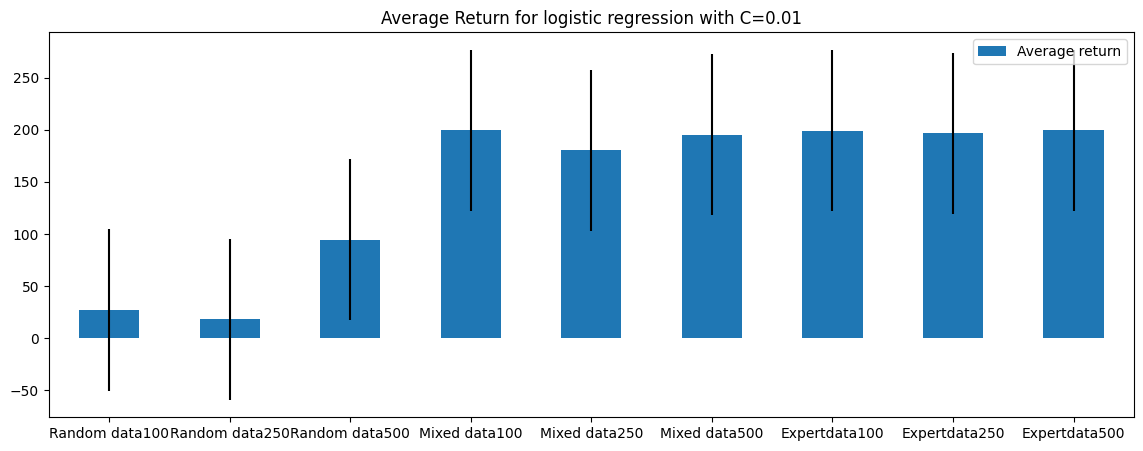

In [114]:
df = pd.DataFrame({'data':['Random data100','Random data250','Random data500','Mixed data100','Mixed data250','Mixed data500','Expertdata100', 'Expertdata250', 'Expertdata500'], 'Average return':[average_return_random100_C01,average_return_random250_C01,average_return_random500_C01,average_return_mixed100_C01,average_return_mixed250_C01,average_return_mixed500_C01,average_return_expert100_C01, average_return_expert250_C01, average_return_expert500_C01]})
# Create a DataFrame from the data
df = pd.DataFrame({'data': data, 'Average return': avg})

# Calculate the standard deviation of the 'Average return' column
std = df['Average return'].std()

# Create the plot
ax = df.plot.bar(x='data', y='Average return', yerr=std, rot=0, figsize=(14, 5))

# Set x-label to an empty string
plt.xlabel('')
# Add a title to the plot
plt.title('Average Return for logistic regression with C=0.01')
plt.show()


# Fitted q learning


## Expert dataset

### Expert dataset 100 episodes

In [115]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


 50%|█████     | 50/100 [00:16<00:16,  3.11it/s]

Training stopped at epoch 51


In [116]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_100_C1 = total_rewards / 100
print("Average reward: ", average_reward_expert_100_C1)

Average reward:  152.48


In [117]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_100_C01 = total_rewards / 100
print("Average reward: ", average_reward_expert_100_C01)

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


Average reward:  45.54


### Expert dataset 250 episodes

In [118]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


 25%|██▌       | 25/100 [00:17<00:51,  1.45it/s]

Training stopped at epoch 26


In [119]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_250_C1 = total_rewards / 100
print("Average reward: ", average_reward_expert_250_C1)

Average reward:  190.56


In [120]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_250_C001 = total_rewards / 100
print("Average reward: ", average_reward_expert_250_C001)

 57%|█████▋    | 57/100 [00:22<00:14,  2.91it/s]/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-120-350e68117658>:33: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
 58%|█████▊    | 58/100 [00:22<00:15,  2.79it/s]<ipython-input-120-350e68117658>:36: RuntimeWarning: invalid value encountered in double_scalars
  if abs(mse - prev_mse) < epsilon:
100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


Average reward:  27.83


### Expert dataset 500 episodes

In [121]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


 17%|█▋        | 17/100 [00:15<01:13,  1.13it/s]

Training stopped at epoch 18


In [122]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_500C001 = total_rewards / 100
print("Average reward: ", average_reward_expert_500C001)

Average reward:  205.84


In [123]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in expert_dataset500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_expert_500_C1 = total_rewards / 100
print("Average reward: ", average_reward_expert_500_C1)


 25%|██▌       | 25/100 [00:20<01:11,  1.05it/s]<ipython-input-123-49d363aab3ab>:33: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
 26%|██▌       | 26/100 [00:21<01:05,  1.13it/s]<ipython-input-123-49d363aab3ab>:36: RuntimeWarning: invalid value encountered in double_scalars
  if abs(mse - prev_mse) < epsilon:
 50%|█████     | 50/100 [00:42<00:44,  1.13it/s]<ipython-input-123-49d363aab3ab>:29: RuntimeWarning: overflow encountered in add
  grad[:, action] += state * error  # accumulate gradient for current time step
<ipython-input-123-49d363aab3ab>:29: RuntimeWarning: invalid value encountered in multiply
  grad[:, action] += state * error  # accumulate gradient for current time step
<ipython-input-123-49d363aab3ab>:28: RuntimeWarning: invalid value encountered in double_scalars
  error = q_pred[action] - y[t,:][action]
<ipython-input-123-49d363aab3ab>:33: RuntimeWarning: invalid value

Average reward:  9.27


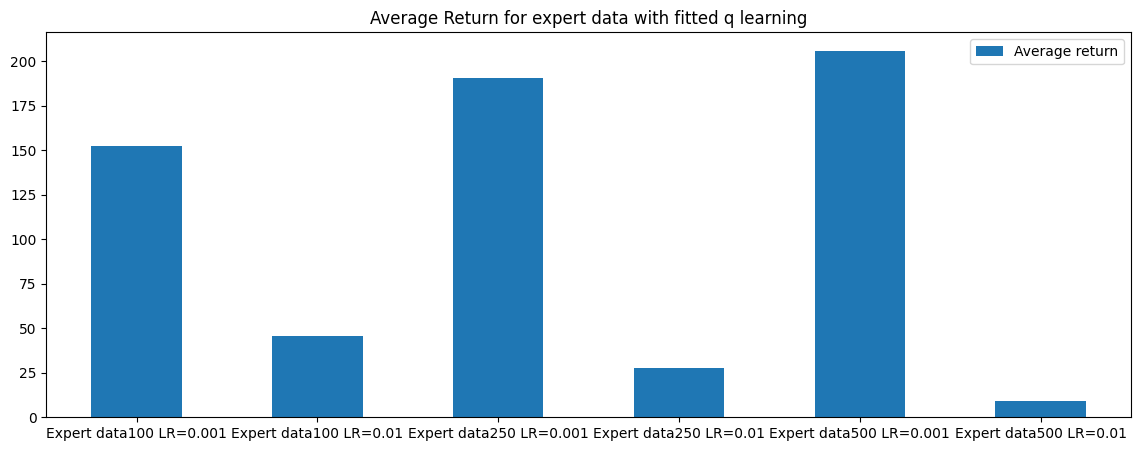

In [124]:
import pandas as pd

df = pd.DataFrame({'data':['Expert data100 LR=0.001','Expert data100 LR=0.01','Expert data250 LR=0.001','Expert data250 LR=0.01','Expert data500 LR=0.001','Expert data500 LR=0.01'], 'Average return':[average_reward_expert_100_C1,average_reward_expert_100_C01,average_reward_expert_250_C1,average_reward_expert_250_C001,average_reward_expert_500C001,average_reward_expert_500_C1]})
ax = df.plot.bar(x='data', y='Average return', rot=0, figsize=(14,5))
# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for expert data with fitted q learning')
plt.show()

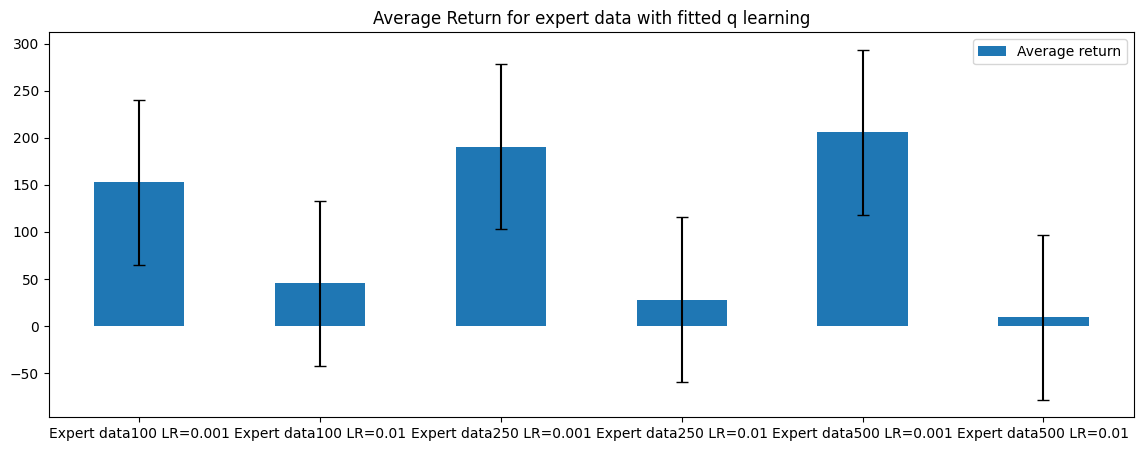

In [125]:

# Define the data
data = [
    ('Expert data100 LR=0.001', average_reward_expert_100_C1),
    ('Expert data100 LR=0.01', average_reward_expert_100_C01),
    ('Expert data250 LR=0.001', average_reward_expert_250_C1),
    ('Expert data250 LR=0.01', average_reward_expert_250_C001),
    ('Expert data500 LR=0.001', average_reward_expert_500C001),
    ('Expert data500 LR=0.01', average_reward_expert_500_C1)
]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['data', 'Average return'])

# Calculate the standard deviation of the 'Average return' column
std = df['Average return'].std()

# Create the plot
ax = df.plot.bar(x='data', y='Average return', yerr=std, capsize=4, rot=0, figsize=(14, 5))

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for expert data with fitted q learning')

plt.show()

## Random dataset 

### Random dataset 100 episodes


In [130]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


In [131]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_100_001 = total_rewards / 100
print("Average reward: ", average_reward_random_100_001)

Average reward:  187.37


In [132]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_100_01 = total_rewards / 100
print("Average reward: ", average_reward_random_100_01)

 57%|█████▋    | 57/100 [00:02<00:01, 24.17it/s]


Training stopped at epoch 58
Average reward:  88.38


### Random dataset 250 episodes

In [133]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


In [134]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_250_001 = total_rewards / 100
print("Average reward: ", average_reward_random_250_001)

Average reward:  140.22


In [135]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_250_01 = total_rewards / 100
print("Average reward: ", average_reward_random_250_01)

 40%|████      | 40/100 [00:03<00:05, 10.47it/s]


Training stopped at epoch 41
Average reward:  84.75


### Random dataset 500 episodes

In [141]:
# Set learning rates
lr = 0.0001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


In [145]:

total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_500_001 = total_rewards / 100
print("Average reward: ", average_reward_random_500_001)

Average reward:  139.24


In [143]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in random_dataset500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_random_500_01 = total_rewards / 100
print("Average reward: ", average_reward_random_500_01)

 16%|█▌        | 16/100 [00:06<00:31,  2.63it/s]

Training stopped at epoch 17


Average reward:  143.28


In [139]:
df = pd.DataFrame({'data':['Random data100 LR=0.001','Random data100 LR=0.01','Random data250 LR=0.001','Random data250 LR=0.01','Random data500 LR=0.001','Random data500 LR=0.01'], 'Average return':[average_reward_random_100_001,average_reward_random_100_01,average_reward_random_250_001,average_reward_random_250_01,average_reward_random_500_001,average_reward_random_500_01]})


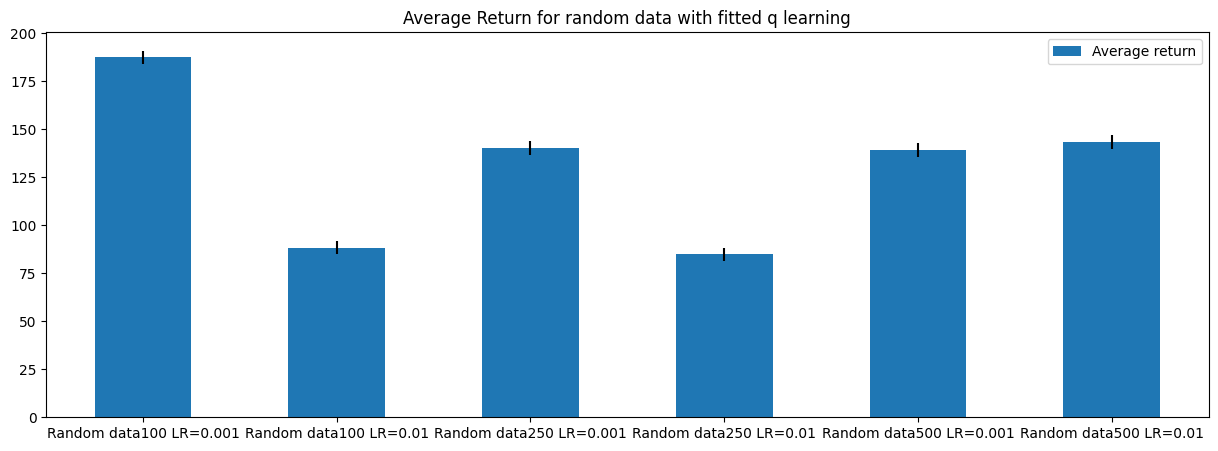

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the data
data = ['Random data100 LR=0.001', 'Random data100 LR=0.01', 'Random data250 LR=0.001', 'Random data250 LR=0.01', 'Random data500 LR=0.001', 'Random data500 LR=0.01']
average_return = [average_reward_random_100_001, average_reward_random_100_01, average_reward_random_250_001, average_reward_random_250_01, average_reward_random_500_001, average_reward_random_500_01]
n = 100 # number of episodes

# Calculate standard error
std_dev = np.std(average_return)
standard_error = std_dev / np.sqrt(n)

# Create a DataFrame with the data and standard error
df = pd.DataFrame({'data': data, 'Average return': average_return, 'Standard error': [standard_error]*6})

# Plot the bar chart with error bars
ax = df.plot.bar(x='data', y='Average return', yerr='Standard error', rot=0, figsize=(15,5))

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for random data with fitted q learning')

plt.show()



## Mixed dataset

### Mixed dataset 100 episodes

In [149]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_100_001 = total_rewards / 100
print("Average reward: ", average_reward_mixed_100_001)

 69%|██████▉   | 69/100 [00:23<00:10,  2.93it/s]

Training stopped at epoch 70


Average reward:  162.3


In [150]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data100:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_100_01 = total_rewards / 100
print("Average reward: ", average_reward_mixed_100_01)

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Average reward:  34.24


### Mixed dataset 250 episodes

In [151]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_250_001 = total_rewards / 100
print("Average reward: ", average_reward_mixed_250_001)

 58%|█████▊    | 58/100 [00:18<00:13,  3.05it/s]


Training stopped at epoch 59
Average reward:  150.5


In [152]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data250:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_250_01 = total_rewards / 100
print("Average reward: ", average_reward_mixed_250_01)

 98%|█████████▊| 98/100 [00:35<00:00,  3.41it/s]/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-152-c734b0acef11>:33: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
 99%|█████████▉| 99/100 [00:35<00:00,  3.26it/s]<ipython-input-152-c734b0acef11>:36: RuntimeWarning: invalid value encountered in double_scalars
  if abs(mse - prev_mse) < epsilon:
100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Average reward:  15.31


### Mixed dataset 500 episodes

In [153]:
# Set learning rates
lr = 0.001
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs
mse_list=[]
# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_500_001 = total_rewards / 100
print("Average reward: ", average_reward_mixed_500_001)

 26%|██▌       | 26/100 [00:22<01:03,  1.17it/s]

Training stopped at epoch 27


Average reward:  196.72


In [154]:
# Set learning rates
lr = 0.01
gamma = 0.99
weights = np.random.uniform(low=-.001, high=.001, size=(phi.num_features, env.action_space.n))
threshold = 1e-2
epsilon = 1e-2 # threshold for difference between consecutive MSEs

# Train Q function with fitted Q learning
prev_mse = np.inf
for epoch in tqdm(range(100)):
    mse = 0  # initialize mean squared error to zero for each epoch
    
    for episode in mixed_data500:
        grad = np.zeros((phi.num_features, env.action_space.n))  # initialize gradient to zero for each epoch

        y =  np.zeros((len(episode), env.action_space.n))   # initialize target values for Q-function update
        q_pred_all = np.zeros((len(episode), env.action_space.n))  # initialize predictions for all time steps in episode
        for t in range(len(episode)):
            state, action, reward, next_state, done = episode[t]
            q_next = next_state.dot(weights)
            Q_next = np.max(q_next) if not done else 0  # set Q_next to 0 if episode has ended

            y[t,:] = reward + gamma * Q_next

            q_pred = state.dot(weights)
            q_pred_all[t, :] = q_pred  # accumulate predictions for current time step

            error = q_pred[action] - y[t,:][action]
            grad[:, action] += state * error  # accumulate gradient for current time step

        weights -= lr * grad  # update weights after each epoch 

        mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
        mse_list.append(mse)  # store MSE in list for plotting later
        
    if abs(mse - prev_mse) < epsilon:
        print(f"Training stopped at epoch {epoch+1}")
        break
    else:
        prev_mse = mse


total_rewards = 0
for episode in range(100):
    state,_ = env.reset()
    state_bins = phi(state)
    done = False
    t=0
    while not done:
        q_value = state_bins.dot(weights)
        action = np.argmax(q_value)
        next_state, reward, done, info,_ = env.step(action)
        total_rewards += reward
        next_state_bins = phi(next_state)
        state_bins = next_state_bins
        t+=1
average_reward_mixed_500_01 = total_rewards / 100
print("Average reward: ", average_reward_mixed_500_01)

 45%|████▌     | 45/100 [00:40<00:55,  1.01s/it]<ipython-input-154-c8b433fdaa83>:33: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - q_pred_all)**2)  # compute mean squared error over all time steps in the episode
 46%|████▌     | 46/100 [00:41<00:52,  1.03it/s]<ipython-input-154-c8b433fdaa83>:36: RuntimeWarning: invalid value encountered in double_scalars
  if abs(mse - prev_mse) < epsilon:
 92%|█████████▏| 92/100 [01:17<00:05,  1.58it/s]<ipython-input-154-c8b433fdaa83>:29: RuntimeWarning: overflow encountered in add
  grad[:, action] += state * error  # accumulate gradient for current time step
100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Average reward:  9.39


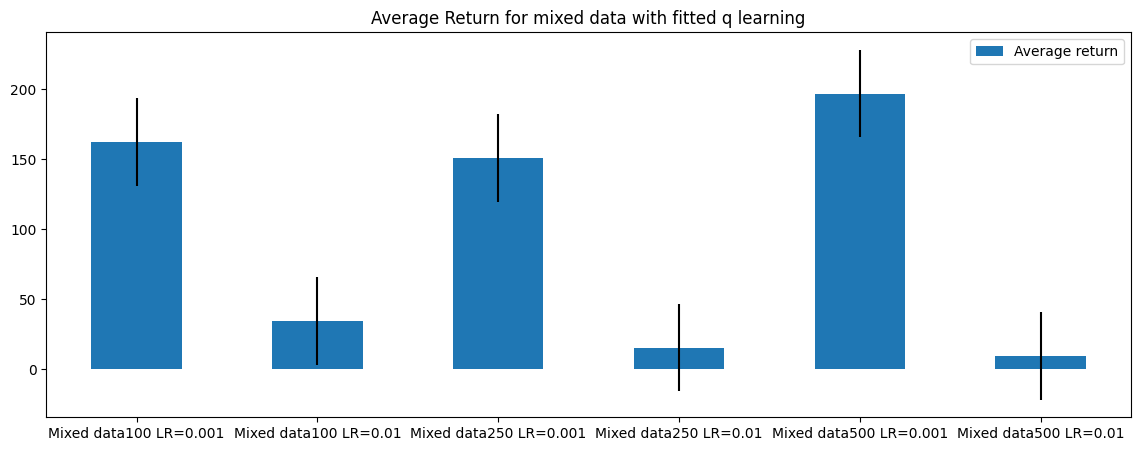

In [157]:
import pandas as pd

data = ['Mixed data100 LR=0.001', 'Mixed data100 LR=0.01', 'Mixed data250 LR=0.001', 'Mixed data250 LR=0.01', 'Mixed data500 LR=0.001', 'Mixed data500 LR=0.01']
average_returns = [average_reward_mixed_100_001, average_reward_mixed_100_01, average_reward_mixed_250_001, average_reward_mixed_250_01, average_reward_mixed_500_001, average_reward_mixed_500_01]

std_dev = np.std(average_returns)
std_err = std_dev / np.sqrt(len(average_returns))

df = pd.DataFrame({'data': data, 'Average return': average_returns, 'Std dev': [std_dev]*len(data), 'Std err': [std_err]*len(data)})

ax = df.plot.bar(x='data', y='Average return', yerr='Std err', rot=0, figsize=(14,5))

# Set x-label to an empty string
plt.xlabel('')

plt.title('Average Return for mixed data with fitted q learning')

# Show the plot
plt.show()





22.03


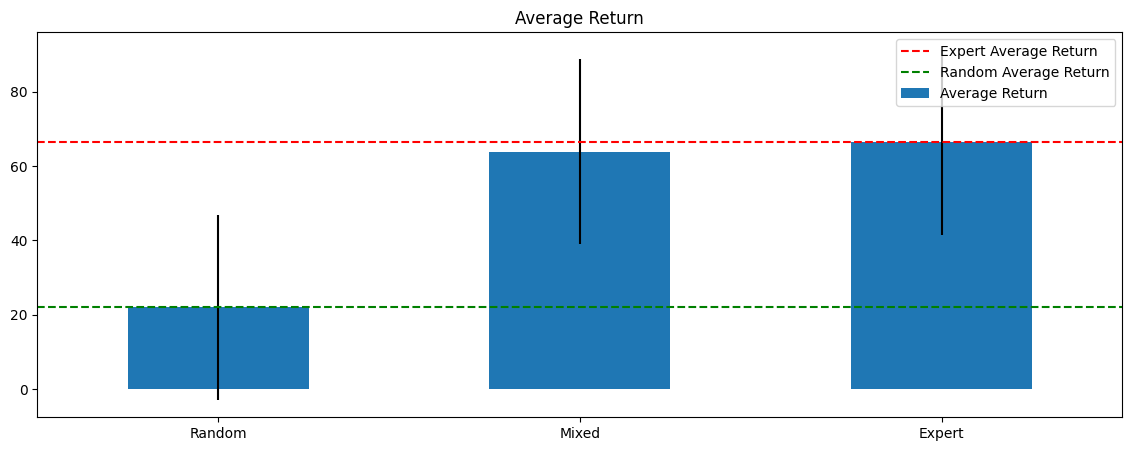

In [201]:
import pandas as pd
import matplotlib.pyplot as plt



average_return_random = sum(sum([r for _, _, r, _, _ in ep]) for ep in random_dataset100) / len(random_dataset100)
# print(average_return_random)
average_return_mixed = sum(sum([r for _, _, r, _, _ in ep]) for ep in mixed_data100) / len(mixed_data100)
average_return_expert = sum(sum([r for _, _, r, _, _ in ep]) for ep in expert_dataset100) / len(expert_dataset100)

avg = [average_return_random, average_return_mixed, average_return_expert]
data = ['Random', 'Mixed', 'Expert']

# Create a DataFrame from the data
df = pd.DataFrame({'Policy': data, 'Average Return': avg})

# Calculate the standard deviation of the 'Average Return' column
std = df['Average Return'].std()

# Create the plot
ax = df.plot.bar(x='Policy', y='Average Return', yerr=std, rot=0, figsize=(14, 5))

# Add horizontal lines for the average return of the expert and random policy
plt.axhline(y=average_return_expert, color='r', linestyle='--', label='Expert Average Return')
plt.axhline(y=average_return_random, color='g', linestyle='--', label='Random Average Return')

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for data size 100')

# Add a legend to the plot
plt.legend()

plt.show()


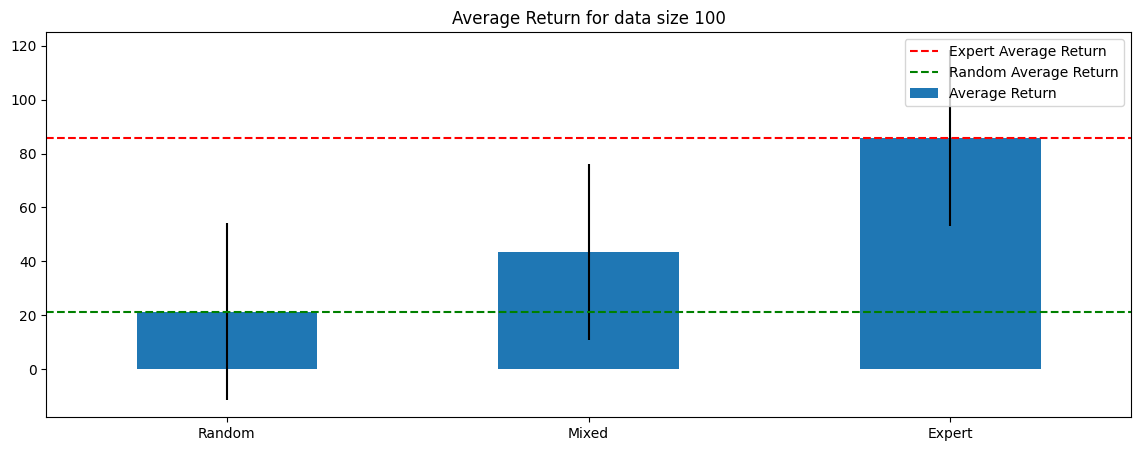

In [202]:
import pandas as pd
import matplotlib.pyplot as plt



average_return_random = sum(sum([r for _, _, r, _, _ in ep]) for ep in random_dataset250) / len(random_dataset250)
# print(average_return_random)
average_return_mixed = sum(sum([r for _, _, r, _, _ in ep]) for ep in mixed_data250) / len(mixed_data250)
average_return_expert = sum(sum([r for _, _, r, _, _ in ep]) for ep in expert_dataset250) / len(expert_dataset250)

avg = [average_return_random, average_return_mixed, average_return_expert]
data = ['Random', 'Mixed', 'Expert']

# Create a DataFrame from the data
df = pd.DataFrame({'Policy': data, 'Average Return': avg})

# Calculate the standard deviation of the 'Average Return' column
std = df['Average Return'].std()

# Create the plot
ax = df.plot.bar(x='Policy', y='Average Return', yerr=std, rot=0, figsize=(14, 5))

# Add horizontal lines for the average return of the expert and random policy
plt.axhline(y=average_return_expert, color='r', linestyle='--', label='Expert Average Return')
plt.axhline(y=average_return_random, color='g', linestyle='--', label='Random Average Return')

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for data size 250')

# Add a legend to the plot
plt.legend()

plt.show()


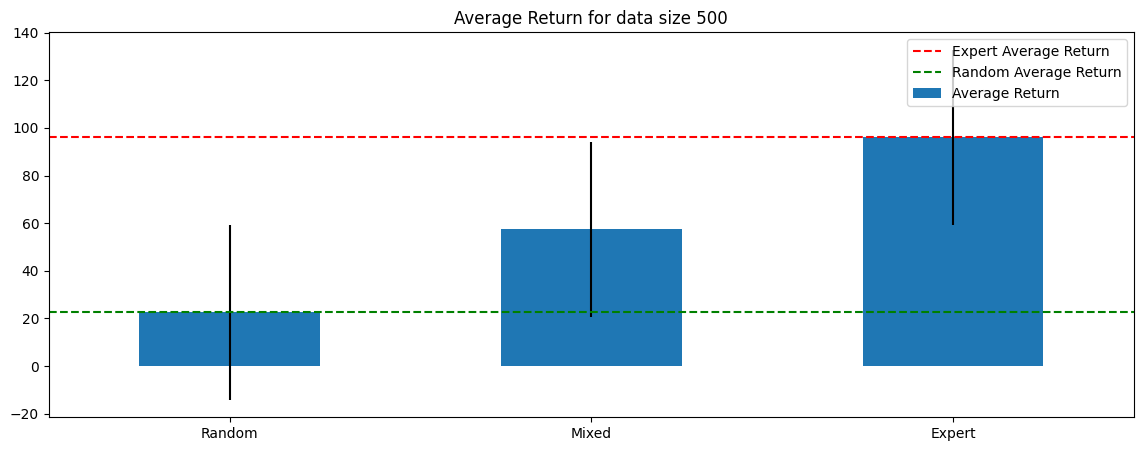

In [203]:
import pandas as pd
import matplotlib.pyplot as plt



average_return_random = sum(sum([r for _, _, r, _, _ in ep]) for ep in random_dataset500) / len(random_dataset500)
# print(average_return_random)
average_return_mixed = sum(sum([r for _, _, r, _, _ in ep]) for ep in mixed_data500) / len(mixed_data500)
average_return_expert = sum(sum([r for _, _, r, _, _ in ep]) for ep in expert_dataset500) / len(expert_dataset500)

avg = [average_return_random, average_return_mixed, average_return_expert]
data = ['Random', 'Mixed', 'Expert']

# Create a DataFrame from the data
df = pd.DataFrame({'Policy': data, 'Average Return': avg})

# Calculate the standard deviation of the 'Average Return' column
std = df['Average Return'].std()

# Create the plot
ax = df.plot.bar(x='Policy', y='Average Return', yerr=std, rot=0, figsize=(14, 5))

# Add horizontal lines for the average return of the expert and random policy
plt.axhline(y=average_return_expert, color='r', linestyle='--', label='Expert Average Return')
plt.axhline(y=average_return_random, color='g', linestyle='--', label='Random Average Return')

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for data size 500')

# Add a legend to the plot
plt.legend()

plt.show()

# Report


\
We implemented two algorithms to solve the cart pole problem. The first was a logistic regression perceptron to imitate the cart enviroment. The second was an on-policy Q-learning implementation. The two implementations were tested with nine datasets.  

The datasets were divided into three sizes and compositions. The sizes were 100, 250, and 500 episodes. The three compositions were drawn from (1) an expert agent, the greedy Q-learning policy, (2) a random agent, and a (3) a 50-50 split of random and expert.


* The stopping condition for both algorithms was the built in 'done' value returned from the step() method of the cart-pole enviroment.


* The agents run with random data performed the worst, and agents with expert data the best. The surprising result was the mixed data performed almost as well as the expert data. From this, we conclude that both algorithms, fitted Q-learning, are quite robust to noise in the data. This noise is in the form of exploration, or random actions. We can conclude that fitted Q learning is a viable algorithm to apply when our dataset contains a large amount of exploration, or noisy, data.




* With the increase of dataset size, we have multiple training examples to train the model on. Hence the performance is better for dataset size 500 comparing to dataset 250 and 100. This is conveyed from the horizontal lines plotted for the different dataset sizes for the expert and random policies above.

* The algorithms did slightly outperform the policies on which they were trained on for mixed and expert, but were about the same for the random policy.


* Fitted q learning with learning rate 0.001 has reached the maximum average rewards for the three sizes of datasets under three different conditions.

* For logistic regression algorithm, C=0.01 has also outperformed C=0.1.

* The expert policy outperformed the two other policies ( mixed and random) for both algorithms which is certainly what we expected.


* The stopping condition for the training of fitted q learning algorithm was built upon the Mean squared error. The idea is to monitor the MSE between the predicted Q-values and the target Q-values during the training process. During the training process, the agent updates its Q-values using the current estimate of the target Q-values. The goal is to minimize the difference between the predicted Q-values and the target Q-values. If the MSE between the predicted and target Q-values stops decreasing or become stable, it indicates that the algorithm has reached a plateau or is overfitting the data. Therefore, we decided to stop the training.



# MLP

In [171]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset100 for t in episode])
y = np.hstack([t[1] for episode in random_dataset100 for t in episode])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [173]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_random100=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  21.29


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset250 for t in episode])
y = np.hstack([t[1] for episode in random_dataset250 for t in episode])

In [175]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [176]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_random250=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  29.23


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [177]:
X = np.vstack([np.hstack((t[0])) for episode in random_dataset500 for t in episode])
y = np.hstack([t[1] for episode in random_dataset500 for t in episode])

In [178]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [179]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_random500=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  60.81


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = np.vstack([np.hstack((t[0])) for episode in expert_dataset100 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset100 for t in episode])
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [181]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_expert100=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  124.92


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [182]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = np.vstack([np.hstack((t[0])) for episode in expert_dataset250 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset250 for t in episode])
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [183]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_expert250=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  182.05


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
X = np.vstack([np.hstack((t[0])) for episode in expert_dataset500 for t in episode])
y = np.hstack([t[1] for episode in expert_dataset500 for t in episode])

In [185]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [186]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_expert500=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  185.53


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [188]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = np.vstack([np.hstack((t[0])) for episode in mixed_data100 for t in episode])
y = np.hstack([t[1] for episode in mixed_data100 for t in episode])
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [189]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_mixed100=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  183.97


In [190]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = np.vstack([np.hstack((t[0])) for episode in mixed_data250 for t in episode])
y = np.hstack([t[1] for episode in mixed_data250 for t in episode])
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [191]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_mixed250=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  163.92


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [192]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = np.vstack([np.hstack((t[0])) for episode in mixed_data500 for t in episode])
y = np.hstack([t[1] for episode in mixed_data500 for t in episode])
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# Train the MLP model
mlp.fit(X, y)



MLPClassifier(max_iter=500)

In [193]:
num_episodes = 100
episode_length = 200

returns = []

for i in range(num_episodes):
    state,_= env.reset()
    episode_return = 0
    
    for t in range(episode_length):
        # Get the action from the policy estimator
        action_probs = mlp.predict_proba(phi(state).reshape(1, -1))
        action = np.argmax(action_probs)
        
        # Take the action and get the next state and reward
        next_state, reward, done, info,_ = env.step(action)
        
        # Update the episode return and current state
        episode_return += reward
        state = next_state
        
        if done:
            break
            
    returns.append(episode_return)
average_return_mixed500=   sum(returns) / len(returns)
# Print the average return over the 100 episodes
print("Average Return: ",  sum(returns) / len(returns))




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Return:  181.05


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


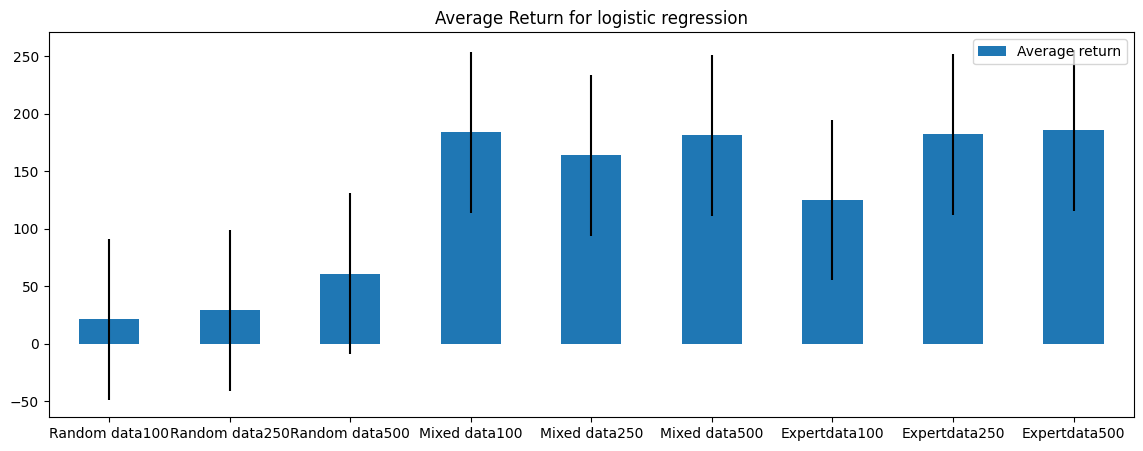

In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
avg = [average_return_random100,average_return_random250,average_return_random500,average_return_mixed100,average_return_mixed250,average_return_mixed500,average_return_expert100, average_return_expert250, average_return_expert500]
data = ['Random data100','Random data250','Random data500','Mixed data100','Mixed data250','Mixed data500','Expertdata100', 'Expertdata250', 'Expertdata500']

# Create a DataFrame from the data
df = pd.DataFrame({'data': data, 'Average return': avg})

# Calculate the standard deviation of the 'Average return' column
std = df['Average return'].std()

# Create the plot
ax = df.plot.bar(x='data', y='Average return', yerr=std, rot=0, figsize=(14, 5))

# Set x-label to an empty string
plt.xlabel('')

# Add a title to the plot
plt.title('Average Return for logistic regression')

plt.show()


## Report MLP 

* As expected expert and mixed policy are close to each other also when using MLP. 
* MLP shows a lower performance than the previously tested algorithms with higher standard deviation error.